## Inverse Problem

This notebook is a simple example of how to solve an inverse problem using pyshdom. It assumes that we have run the 'SimulateRadiances' notebook and saved the result.

In [1]:
#imports

import pyshdom
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
np.random.seed(1)


### Load Measurements

Here we load the synthetic measurements and also all of the inputs to the solver. We will use several of these inputs to perform 'inverse crimes' whereby we fix some aspects of the problem perfectly as in the forward simulation. When using real world measurements no such short cuts are necessary.

* First, we have to look at the measurements and select a region of interest and define our `rte_grid`. 
* Then we have to model the sensor sub-pixel geometry.
* We need to analyze whether the grid and sensor geometry are consistent. The SpaceCarver is useful for this. If not then we may need to change resolution of `rte_grid` to match the resolution of the measurements etc.
* We need to decide how to represent the surface, which is currently fixed.
* We need to decide how to represent the atmosphere.
    * What scattering species are we modelling? What are their optical models? 
    * Which quantities will be unknowns and which are fixed?
    * What will be the abstract state that we will reconstruct? For this we need to set the mapping between the abstract state and the RTE solver.
* Now that we are organized we need to initialize our state vector of unknowns. The method for this initialization may itself be quite involved as starting nearer the answer is better. This typically goes hand in hand with the selection of any fixed variables.
* Lastly we perform the optimization.

In this tutorial we will reconstruct only the `extinction` and we will use forward quantities from the ground truth synthetic measurements for simplicity.

In [2]:
sensors, solvers, rte_grid = pyshdom.util.load_forward_model('./SimulateRadiances.nc')

In [3]:
# Only take the MSPI observations for the retrieval
sensors.popitem('eMAS')
# Keep these two cameras for cross-validation
ground_camera = sensors.popitem('GroundCamera')
side_camera = sensors.popitem('SideViewCamera')

# Perform some cloud masking using a single fixed threshold based on the observation that 
# everywhere else will be very dark.
sensor_list = []
for sensor in sensors['MSPI']['sensor_list']:
    copied = sensor.copy(deep=True)
    weights = np.zeros(sensor.sizes['nrays'])
    ray_mask =np.zeros(sensor.sizes['nrays'], dtype=int)
    
    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=int)
    
    # I have not optimized this threshold whatsoever.
    # Feel free to experiment with the cloud mask threshold. 
    # You can compare the observations
    # with a visualization of the initial_state to evaluate the mask.
    # or look at pyshdom.space_carve.SpaceCarver.project
    ray_mask_pixel[np.where(sensor.I.data > 2e-3)] = 1
    copied['weights'] = ('nrays',sensor.I.data)
    copied['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    sensor_list.append(copied)

space_carver = pyshdom.space_carve.SpaceCarver(rte_grid)
carved_volume = space_carver.carve(sensor_list, agreement=(0.0, 1.0), linear_mode=False)

# remove cloud mask values at outer boundaries to prevent interaction with open boundary conditions.
carved_volume.mask[0] = carved_volume.mask[-1] =carved_volume.mask[:,0] =carved_volume.mask[:,-1] = 0.0
        

In [4]:

# make forward_sensors which will hold synthetic measurements from the evaluation of the forward model.
forward_sensors = sensors.make_forward_sensors()

# add an uncertainty model to the observations.
uncertainty = pyshdom.uncertainties.RadiometricNoiseUncertainty(1e-5, 1e-3)
sensors.add_uncertainty_model('MSPI', uncertainty)

# prepare all of the static inputs to the solver just copy pasted from forward model
surfaces = OrderedDict()
numerical_parameters = OrderedDict()
sources = OrderedDict()
num_stokes = OrderedDict()
background_optical_scatterers = OrderedDict()
for key in forward_sensors.get_unique_solvers():
    surfaces[key] = solvers[key].surface
    numerical_params = solvers[key].numerical_params
    numerical_parameters[key] = numerical_params
    sources[key] = solvers[key].source
    num_stokes[key] = solvers[key]._nstokes
    background_optical_scatterers[key] = {'rayleigh': solvers[key].medium['rayleigh']}


/Library/anaconda3/envs/pyshdom/lib/python3.9/site-packages/pyshdom/uncertainties.py:69: UserWarning: `inverse_covariance` of errors in uninvertible.It cannot be used to generate noise and will cause an exception to be raised if attempted.
  warnings.warn("`inverse_covariance` of errors in uninvertible."


In [5]:
# set the generator for the unknown scatterer using ground truth optical properties
# and unknown extinction.
# GridToOpticalProperties holds the fixed optical properties and forms a full set of optical properties
# when it is called with extinction as the argument.

optical_properties = solvers[0.86].medium['cloud'].copy(deep=True)
optical_properties = optical_properties.drop_vars('extinction')

# We are using the ground_truth rte_grid.
grid_to_optical_properties = pyshdom.medium.GridToOpticalProperties(
    rte_grid,'cloud', 0.86,optical_properties
)

# UnknownScatterers is a container for all of the unknown variables.
# Each unknown_scatterer also records the transforms from the abstract state vector
# to the gridded data in physical coordinates.
unknown_scatterers = pyshdom.containers.UnknownScatterers(
    pyshdom.medium.UnknownScatterer(grid_to_optical_properties,
    extinction=(None, pyshdom.transforms.StateToGridMask(mask=carved_volume.mask.data)))
)

In [6]:
# now we form state_gen which updates the solvers with an input_state.
solvers_reconstruct = pyshdom.containers.SolversDict()

state_gen = pyshdom.medium.StateGenerator(solvers_reconstruct,
                                         unknown_scatterers, surfaces,
                                         numerical_parameters, sources, background_optical_scatterers,
                                         num_stokes)

In [7]:
# get bounds automatically.
min_bounds, max_bounds = state_gen.transform_bounds()

In [8]:
# transform initial physical state to abstract state. 
initial_gridded_extinction = carved_volume.mask.data.astype(float)*0.1
initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['extinction'].state_to_grid.inverse_transform(initial_gridded_extinction)
x0 = state_gen._unknown_scatterers['cloud'].variables['extinction'].coordinate_transform.inverse_transform(initial_1d_extinction)


In [11]:
solvers_reconstruct[0.86].medium['cloud'].extinction.min()

<xarray.DataArray 'extinction' ()>
array(0.)

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.860 micron]
     1  -1.857  0.102E-02    31968    72.73  0.284   [Radiance 0.860 micron]
     2  -3.890  0.101E-02    31968    72.73  0.284   [Radiance 0.860 micron]
     3  -6.321  0.101E-02    31968    72.73  0.284   [Radiance 0.860 micron]
 ! Iterations:      3     Final Criterion:  0.000000   [Radiance 0.860 micron]


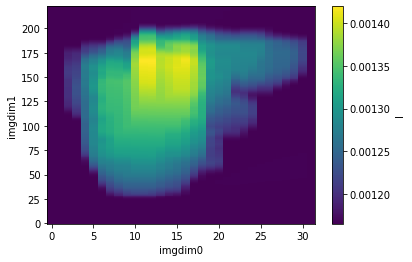

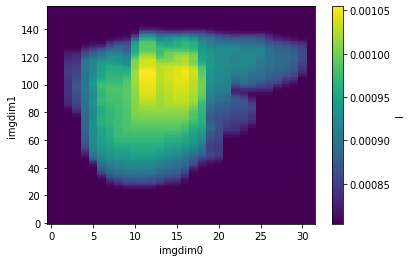

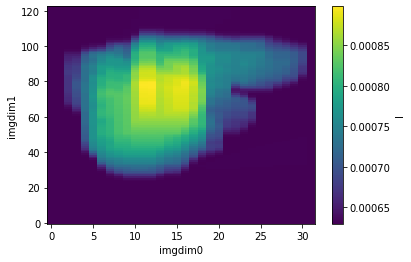

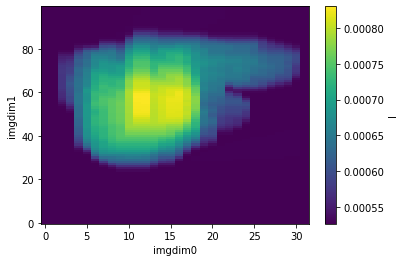

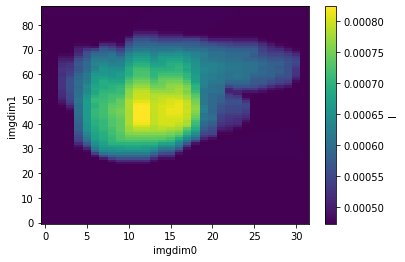

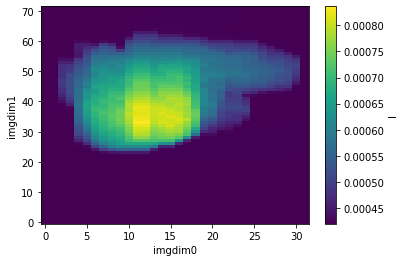

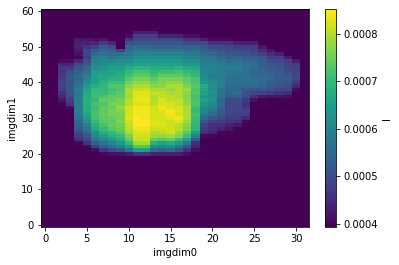

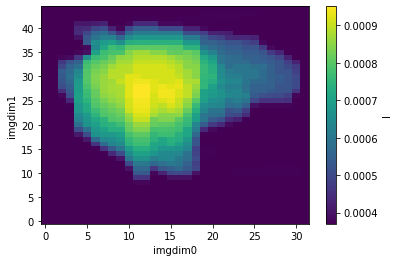

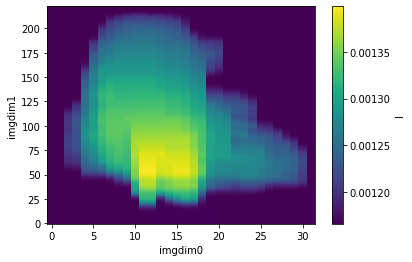

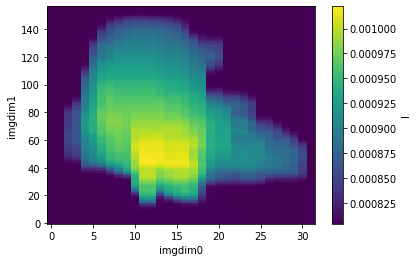

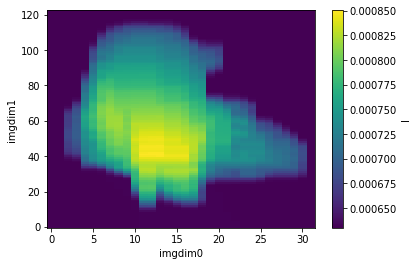

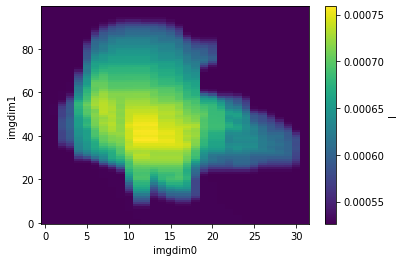

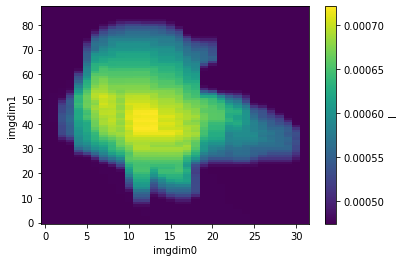

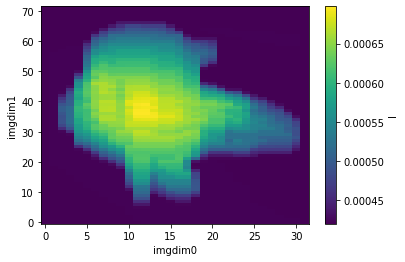

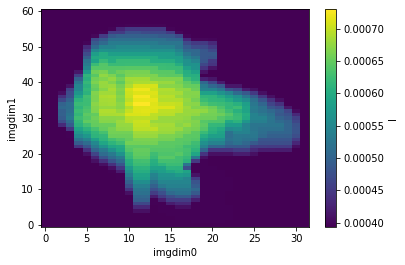

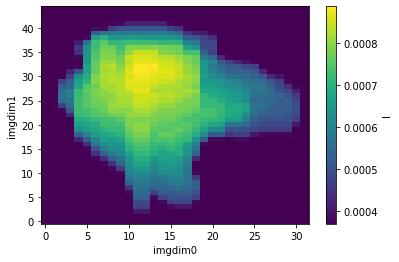

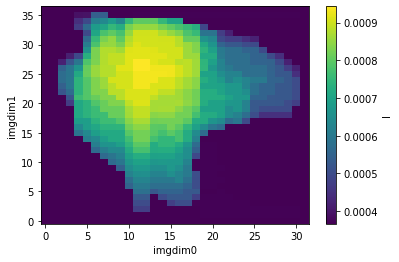

In [10]:
#visualize the initial state
state_gen(x0)
forward_sensors.get_measurements(solvers_reconstruct)

for instrument in forward_sensors:
    for im in forward_sensors.get_images(instrument):
        py.figure()
        im.I.T.plot()

In [12]:

objective_function = pyshdom.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
    sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
  state_gen.project_gradient_to_state,
    parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
  gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
  uncertainty_kwargs={'add_noise': False},
  min_bounds=min_bounds, max_bounds=max_bounds)

In [13]:
def plot():
    for instrument in forward_sensors:
        for im in forward_sensors.get_images(instrument):
            py.figure()
            im.I.T.plot()    
callback = pyshdom.callback.CallbackFn(plot)

In [14]:
# you could add some call back which plots all the synthetic images
# during the iterations if you want.
optimizer = pyshdom.optimize.Optimizer(objective_function)#,
                                      #callback_fn=callback)


In [15]:
import warnings
warnings.filterwarnings('ignore')
# Reduce to just 20 iterations - default is 100.
optimizer._options['maxiter'] = 20
result_other = optimizer.minimize(x0)

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.860 micron]
     1  -1.857  0.102E-02    31968    72.73  0.284   [Radiance 0.860 micron]
     2  -3.890  0.101E-02    31968    72.73  0.284   [Radiance 0.860 micron]
     3  -6.321  0.101E-02    31968    72.73  0.284   [Radiance 0.860 micron]
 ! Iterations:      3     Final Criterion:  0.000000   [Radiance 0.860 micron]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8248     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.37608D+02    |proj g|=  4.38149D-03
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.860 micron]
     1  -1.846  0.104E-02    31968    72.73  0.284   [Radiance 0.860 micron]
     2  -3.868  0.102E-02    31968    72.73  0.284   [Radiance 0.860 micron]
     3  -6.289  0.102E-02    31968    72.73  0.284   [Radiance 0.860 micron]
 ! Iterations:      3     Final Criterion:  0.000001   [Radiance 0.860 micron]

At


At iterate    7    f=  1.34960D+01    |proj g|=  1.27221D-03
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.860 micron]
     1  -0.680  0.287E+00    31968    59.13  0.231   [Radiance 0.860 micron]
     2  -1.218  0.312E+00    31968    59.13  0.231   [Radiance 0.860 micron]
     3  -1.603  0.312E+00    31968    59.13  0.231   [Radiance 0.860 micron]
     4  -1.891  0.230E+00    32046    59.61  0.233   [Radiance 0.860 micron]
     5  -2.362  0.136E+00    32377    61.43  0.240   [Radiance 0.860 micron]
     6  -2.392  0.722E-01    34027    69.87  0.273   [Radiance 0.860 micron]
     7  -2.450  0.515E-01    36268    80.35  0.314   [Radiance 0.860 micron]
     8  -2.623  0.415E-01    38700    90.45  0.353   [Radiance 0.860 micron]
     9  -2.669  0.327E-01    42236   103.24  0.403   [Radiance 0.860 micron]
    10  -2.865  0.300E-01    43925   108.48  0.424   [Radiance 0.860 micron]
    11  -3.174  0.300E-01    43962   108.59  0.424   [Radiance 0.860 micron]
    12  -3.402  0

    15  -4.063  0.302E-01    50720   126.66  0.495   [Radiance 0.860 micron]
 ! Iterations:     15     Final Criterion:  0.000086   [Radiance 0.860 micron]

At iterate   13    f=  4.05194D+00    |proj g|=  1.23413D-03
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.860 micron]
     1  -0.688  0.390E+00    31968    57.54  0.225   [Radiance 0.860 micron]
     2  -1.239  0.427E+00    31968    57.54  0.225   [Radiance 0.860 micron]
     3  -1.603  0.440E+00    31968    57.54  0.225   [Radiance 0.860 micron]
     4  -1.874  0.302E+00    32018    57.84  0.226   [Radiance 0.860 micron]
     5  -2.311  0.168E+00    32395    60.03  0.234   [Radiance 0.860 micron]
     6  -2.312  0.854E-01    34467    70.90  0.277   [Radiance 0.860 micron]
     7  -2.361  0.608E-01    37299    84.20  0.329   [Radiance 0.860 micron]
     8  -2.524  0.492E-01    39927    94.69  0.370   [Radiance 0.860 micron]
     9  -2.551  0.384E-01    44421   109.91  0.429   [Radiance 0.860 micron]
    10  -2.667 

     8  -2.489  0.516E-01    39934    94.86  0.371   [Radiance 0.860 micron]
     9  -2.548  0.406E-01    44425   110.02  0.430   [Radiance 0.860 micron]
    10  -2.635  0.341E-01    48846   122.20  0.477   [Radiance 0.860 micron]
    11  -2.729  0.300E-01    52917   131.76  0.515   [Radiance 0.860 micron]
    12  -3.028  0.300E-01    53069   132.04  0.516   [Radiance 0.860 micron]
    13  -3.264  0.300E-01    53069   132.04  0.516   [Radiance 0.860 micron]
    14  -3.397  0.300E-01    53069   132.04  0.516   [Radiance 0.860 micron]
    15  -3.896  0.300E-01    53069   132.04  0.516   [Radiance 0.860 micron]
    16  -4.147  0.300E-01    53069   132.04  0.516   [Radiance 0.860 micron]
 ! Iterations:     16     Final Criterion:  0.000071   [Radiance 0.860 micron]

At iterate   19    f=  2.97245D+00    |proj g|=  3.45035D-04
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.860 micron]
     1  -0.692  0.423E+00    31968    56.81  0.222   [Radiance 0.860 micron]
     2  -1.244 

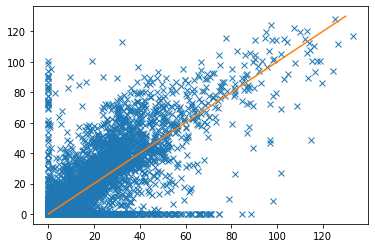

In [16]:
# Take a look  at the result.
py.figure()
py.plot(solvers_reconstruct[0.86].medium['cloud'].extinction.data.ravel(), 
        solvers[0.86].medium['cloud'].extinction.data.ravel(),'x')
py.plot([0,130],[0,130])

In [ ]:
# continue minimizing for another 20 iterations if you like.
optimizer._options['maxiter'] = 100
improve_result = optimizer.minimize(state_gen.get_state())

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.860 micron]
     1  -0.692  0.423E+00    31968    56.81  0.222   [Radiance 0.860 micron]
     2  -1.244  0.469E+00    31968    56.81  0.222   [Radiance 0.860 micron]
     3  -1.608  0.488E+00    31968    56.81  0.222   [Radiance 0.860 micron]
     4  -1.879  0.326E+00    32007    57.05  0.223   [Radiance 0.860 micron]
     5  -2.303  0.177E+00    32421    59.44  0.232   [Radiance 0.860 micron]
     6  -2.279  0.888E-01    34508    70.41  0.275   [Radiance 0.860 micron]
     7  -2.347  0.643E-01    37218    83.24  0.325   [Radiance 0.860 micron]
     8  -2.487  0.515E-01    40004    94.29  0.368   [Radiance 0.860 micron]
     9  -2.542  0.406E-01    44440   109.40  0.427   [Radiance 0.860 micron]
    10  -2.633  0.343E-01    48777   121.31  0.474   [Radiance 0.860 micron]
    11  -2.737  0.300E-01    53007   131.23  0.513   [Radiance 0.860 micron]
    12  -3.015  0.300E-01    53173   131.54  0.514   [Radiance 0.860 micron]
  

In [18]:
%matplotlib qt
for instrument in forward_sensors:
    for im1,im2 in zip(forward_sensors.get_images(instrument),
                       sensors.get_images(instrument)):
        fig,ax = py.subplots(1,3)
        im1.I.T.plot(ax=ax[0])
        im2.I.T.plot(ax=ax[1])
        (im1.I-im2.I).T.plot(ax=ax[2])

In [21]:
py.figure()
solvers_reconstruct[0.86].medium['cloud'].extinction[16].T.plot()
py.figure()
solvers[0.86].medium['cloud'].extinction[16].T.plot()